# MAGIC

In [1]:
import numpy as np
import scanpy as sc
from util import normalize_rows, mse

from sklearn.utils.extmath import randomized_svd
import magic
import scprep
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
emt_data = scprep.io.load_csv('/Users/josh/src/noise2self-single-cell/data/magic/HMLE_TGFb_day_8_10.csv.gz')
emt_data = scprep.filter.remove_empty_genes(emt_data)


In [69]:
x1 = np.random.binomial(emt_data.values, 0.5)
x2 = emt_data.values - x1

In [70]:
emt1 = pd.DataFrame(data = x1, index = emt_data.index, columns = emt_data.columns)
emt2 = pd.DataFrame(data = x2, index = emt_data.index, columns = emt_data.columns)

In [71]:
emt1 = scprep.normalize.library_size_normalize(emt1)
#emt1 = scprep.transform.sqrt(emt1)

emt2 = scprep.normalize.library_size_normalize(emt2)
#emt2 = scprep.transform.sqrt(emt2)

In [72]:
genes = ['VIM', 'CDH1', 'ZEB1', 'SNAI1', 'EZH2', 'MYC', 'MT-ND1']

In [73]:
magic_op = magic.MAGIC()
emt_magic = magic_op.fit_transform(emt1, genes=genes)

Calculating MAGIC...
  Running MAGIC on 7523 cells and 28909 genes.
  Calculating graph and diffusion operator...


/Users/josh/.local/lib/python3.6/site-packages/magic/magic.py:376: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn("Input matrix contains unexpressed genes. "


    Calculating PCA...
    Calculated PCA in 115.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 31.32 seconds.
    Calculating affinities...
    Calculated affinities in 10.67 seconds.
  Calculated graph and diffusion operator in 160.08 seconds.
  Calculating imputation...
    Automatically selected t = 8
  Calculated imputation in 4.67 seconds.
Calculated MAGIC in 175.16 seconds.


In [37]:
magic.plot.animate_magic(emt1, gene_x = 'VIM', gene_y = 'CDH1', 
                         gene_color = 'ZEB1', operator=magic_op)

In [75]:
data1 = scprep.select.select_cols(emt1, idx=genes)
data2 = scprep.select.select_cols(emt2, idx=genes)

In [76]:
magic_sweep = [data1]
t_max = 20
for t in range(t_max):
    magic_op.set_params(t=t + 1)
    magic_sweep.append(magic_op.transform(genes=genes))

Calculating imputation...
Calculated imputation in 0.71 seconds.
Calculating imputation...
Calculated imputation in 0.99 seconds.
Calculating imputation...
Calculated imputation in 1.09 seconds.
Calculating imputation...
Calculated imputation in 1.37 seconds.
Calculating imputation...
Calculated imputation in 1.64 seconds.
Calculating imputation...
Calculated imputation in 2.08 seconds.
Calculating imputation...
Calculated imputation in 2.34 seconds.
Calculating imputation...
Calculated imputation in 3.32 seconds.
Calculating imputation...
Calculated imputation in 3.46 seconds.
Calculating imputation...
Calculated imputation in 3.85 seconds.
Calculating imputation...
Calculated imputation in 4.39 seconds.
Calculating imputation...
Calculated imputation in 5.74 seconds.
Calculating imputation...
Calculated imputation in 6.76 seconds.
Calculating imputation...
Calculated imputation in 6.07 seconds.
Calculating imputation...
Calculated imputation in 6.69 seconds.
Calculating imputation...

In [77]:
def mse(x,y):
    return ((x - y)**2).mean()

In [78]:
err = pd.DataFrame([mse(x, data2) for x in magic_sweep])

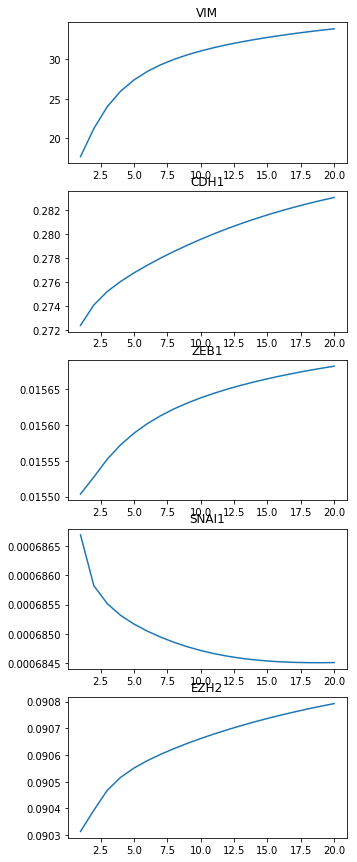

In [79]:
fig, axes = plt.subplots(5, figsize = (5, 15))
for i, ax in enumerate(axes):
    ax.plot(err.iloc[1:,i])
    ax.set_title(err.columns[i])

In [80]:
from scipy.sparse import identity
from copy import deepcopy

In [81]:
lazy_magic_op = deepcopy(magic_op)
lazy_p = 0.5

lazy_magic_op.graph._diff_op = (1 - lazy_p) * lazy_magic_op.diff_op + lazy_p * identity(lazy_magic_op.diff_op.shape[0])

In [82]:
magic_sweep = [data1]
t_max = 20
for t in range(t_max):
    lazy_magic_op.set_params(t=t + 1)
    magic_sweep.append(lazy_magic_op.transform(genes=genes))

Calculating imputation...
Calculated imputation in 0.18 seconds.
Calculating imputation...
Calculated imputation in 0.32 seconds.
Calculating imputation...
Calculated imputation in 0.50 seconds.
Calculating imputation...
Calculated imputation in 0.73 seconds.
Calculating imputation...
Calculated imputation in 0.93 seconds.
Calculating imputation...
Calculated imputation in 2.27 seconds.
Calculating imputation...
Calculated imputation in 2.95 seconds.
Calculating imputation...
Calculated imputation in 1.38 seconds.
Calculating imputation...
Calculated imputation in 1.53 seconds.
Calculating imputation...
Calculated imputation in 2.30 seconds.
Calculating imputation...
Calculated imputation in 3.65 seconds.
Calculating imputation...
Calculated imputation in 1.88 seconds.
Calculating imputation...
Calculated imputation in 2.88 seconds.
Calculating imputation...
Calculated imputation in 2.49 seconds.
Calculating imputation...
Calculated imputation in 3.89 seconds.
Calculating imputation...

In [83]:
err = pd.DataFrame([mse(x, data2) for x in magic_sweep])

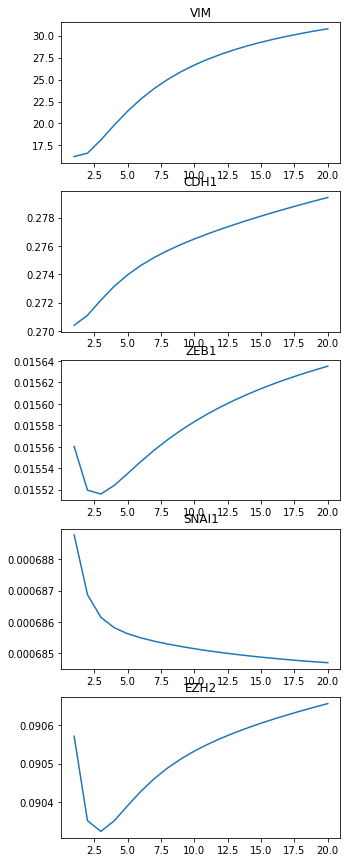

In [84]:
fig, axes = plt.subplots(len(genes), figsize = (5, 15))
for i, ax in enumerate(axes):
    ax.plot(err.iloc[1:,i])
    ax.set_title(err.columns[i])

In [215]:
denoised = magic_sweep[0].copy()
best_err = np.min(err.values, axis = 0)
for g in genes:
    best_t = np.argmin(err[g].values)
    denoised[g] = magic_sweep[best_t][g]

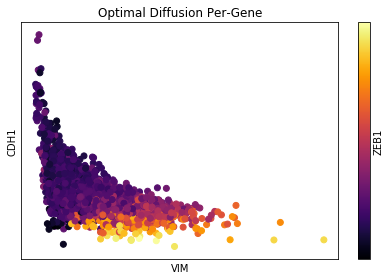

In [218]:
plt.figure()

plt.scatter(denoised['VIM'], denoised['CDH1'], 
            c = denoised['ZEB1'] ,cmap='inferno')

plt.xlabel('VIM')
plt.ylabel('CDH1')
plt.yticks([])
plt.xticks([])
plt.colorbar(label='ZEB1', ticks=[])
plt.title("Optimal Diffusion Per-Gene")
plt.tight_layout()

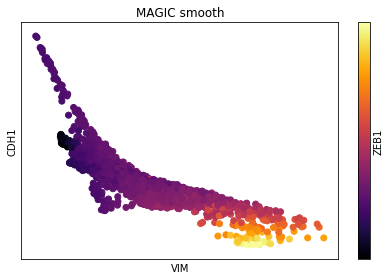

In [87]:
plt.figure()

plt.scatter(magic_sweep[10]['VIM'], magic_sweep[10]['CDH1'], 
            c = magic_sweep[-1]['ZEB1'] ,cmap='inferno')

plt.xlabel('VIM')
plt.ylabel('CDH1')
plt.yticks([])
plt.xticks([])
plt.colorbar(label='ZEB1', ticks=[])
plt.title("MAGIC smooth")
plt.tight_layout()

# Is the data collapsing onto an axis?

Something strange is going on. The magic random walk is not doubly ergodic, ie, it takes probability vectors to probability vectors, but the transpose does not satisfy that. In particular, this means that the fixed point will not be the uniform distribution on the vertices. Things may accumulate sharply.

In [89]:
from scipy.sparse.linalg import eigs
eig_val, eig_v = eigs(magic_op.diff_op)

In [94]:
eig_v[:,0]

array([-0.01152934+0.j, -0.01152934+0.j, -0.01152934+0.j, ...,
       -0.01152934+0.j, -0.01152934+0.j, -0.01152934+0.j])

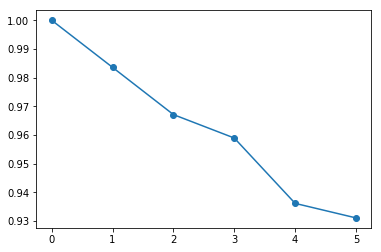

In [96]:
plt.plot(eig_val, marker = 'o')

# Compare PCA

In [163]:
x1_norm = emt1.values
x2_norm = emt2.values

U, S, V = randomized_svd(x1_norm, n_components=20, random_state=42)

ss_loss = []
k_range = np.arange(1, 35)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ss_loss.append(mse(x_pred, x2_norm))
k_opt = k_range[np.argmin(ss_loss)]
                
print(k_opt)

20


In [164]:
x_pred = U[:,:k_opt].dot(np.diag(S[:k_opt])).dot(V[:k_opt,:])
denoised_pca_all = pd.DataFrame(data = x_pred, index = emt_data.index, columns = emt_data.columns)

In [220]:
denoised_pca = scprep.select.select_cols(denoised_pca_all, idx=genes)
err = mse(data2, denoised_pca)
print(err)

VIM     18.165731
CDH1     0.278920
ZEB1     0.011796
dtype: float64


In [222]:
for i in range(len(best_err)):
    print(genes[i], '\t', best_err[i])

VIM 	 15.39154503879472
CDH1 	 0.27933078662277894
ZEB1 	 0.01169116460979211


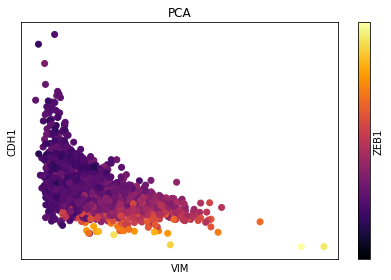

In [224]:
plt.figure()

plt.scatter(denoised_pca['VIM'], denoised_pca['CDH1'], 
            c = denoised_pca['ZEB1'] ,cmap='inferno')

plt.xlabel('VIM')
plt.ylabel('CDH1')
plt.yticks([])
plt.xticks([])
plt.colorbar(label='ZEB1', ticks=[])
plt.title("PCA")
plt.tight_layout()

In [245]:
# Predicted correlation coefficients

corr_magic_per_gene = np.corrcoef(denoised[['CDH1','VIM']].values.T)[0,1]
corr_pca = np.corrcoef(denoised_pca[['CDH1','VIM']].values.T)[0,1]
corr_raw = np.corrcoef(emt1[['CDH1','VIM']].values.T)[0,1]
corr_last_magic = np.corrcoef(magic_sweep[-1][['CDH1','VIM']].values.T)[0,1]

print("Correlations:")
print("Raw \t\t{:.2f}".format(corr_raw))
print("MAGIC per gene \t{:.2f}".format(corr_magic_per_gene))
print("PCA \t\t{:.2f}".format(corr_pca))
print("MAGIC smooth \t{:.2f}".format(corr_last_magic))

Correlations:
Raw 		-0.11
MAGIC per gene 	-0.53
PCA 		-0.46
MAGIC smooth 	-0.84


In [ ]:
np.corrcoef(denoised[['CDH1','VIM']].values.T)[0,1], np.corrcoef(denoised_pca[['CDH1','VIM']].values.T)[0,1], \
np.corrcoef(emt1[['CDH1','VIM']].values.T)[0,1], 